## HR, HK, and PolyX Analysis

This notebook processes the extracted data from `.txt` files and generates visualizations.

In [1]:
# Load necessary libraries
library(tidyverse)
library(readxl)
library(dplyr)
library(conflicted)
conflict_prefer("filter", "dplyr")


Warning message:
"Paket 'ggplot2' wurde unter R Version 4.3.3 erstellt"
Warning message:
"Paket 'tidyr' wurde unter R Version 4.3.3 erstellt"
Warning message:
"Paket 'readr' wurde unter R Version 4.3.3 erstellt"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
[conflicted] Will prefer dplyr::filter over any other package.


## Set the organisms you want to process

In [2]:
# Create a data frame for the UP numbers and organisms
up_to_organism <- tibble(
  UP_number = c("UP000000625", "UP000002311", "UP000006548", "UP000001940", "UP000000803", "UP000000589", "UP000005640"),
  Organism = c("Escherichia coli", "Saccharomyces cerevisiae", "Arabidopsis thaliana", 
               "Caenorhabditis elegans", "Drosophila melanogaster", "Mus musculus", "Homo sapiens")
)

# Display the table using knitr::kable
knitr::kable(up_to_organism, caption = "Mapping of UP Numbers to Organisms")




Table: Mapping of UP Numbers to Organisms

|UP_number   |Organism                 |
|:-----------|:------------------------|
|UP000000625 |Escherichia coli         |
|UP000002311 |Saccharomyces cerevisiae |
|UP000006548 |Arabidopsis thaliana     |
|UP000001940 |Caenorhabditis elegans   |
|UP000000803 |Drosophila melanogaster  |
|UP000000589 |Mus musculus             |
|UP000005640 |Homo sapiens             |

## Select organisms you want to display here.

All organisms with their UP IDs in this list will be processed and shown in the figures.

In [3]:
# Select only the organisms you want to plot
selected_organisms <- c("UP000000589", "UP000000625", "UP000002311", "UP000001940", "UP000000803", "UP000006548")
# "UP000005640",  is excluded

## Load Data

Reading the `.tsv` files into R and combining them into a single dataframe.

In [4]:
# Read in data from .tsv files
file_paths <- list.files("./proteomes_hrs_hk", pattern = "*.tsv", full.names = TRUE)
organism_data <- file_paths %>%
  map_dfr(~read_tsv(.x, show_col_types = FALSE) %>%
            mutate(
              Polyx_lengths = as.character(Polyx_lengths),
              Count_grouped = as.character(Count_grouped),
              Organism = str_remove(tools::file_path_sans_ext(basename(.x)), "_hrs_hk")
            ))
head(organism_data)

HkPolyx <- organism_data %>%
  filter(Organism %in% selected_organisms) %>%  # Filter data for selected organisms
  droplevels() %>%
  mutate(Organism = factor(Organism))

#print(unique(HkPolyx$Organism))

Genename,Uniprot_id,Length,Polyx_count,Polyx_types,Polyx_lengths,Total_length,Pption_polyx,Count_grouped,Hk,Organism
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
Trdv2-1,A0A075B658,115,0,-,0,0,0,0,0,UP000000589
Igkv8-21,A0A140T8P7,120,0,-,0,0,0,0,0,UP000000589
Btbd35f21,A0A140T8Q5,498,0,-,0,0,0,0,0,UP000000589
Cdr2l,A2A6T1,465,0,-,0,0,0,0,0,UP000000589
Pramel29,A2A958,498,0,-,0,0,0,0,0,UP000000589
Patl2,A2ARM1,529,0,-,0,0,0,0,0,UP000000589


## Data Processing

Processing the data to classify HK and count groups properly.

In [5]:
HkPolyx <- HkPolyx %>%
  mutate(Hk = recode(Hk, `0` = "not Hk", `1` = "Hk"),
         Hk = as.factor(Hk),
         Hk = factor(Hk, levels = rev(levels(Hk))),
         Count_grouped = factor(Count_grouped, levels = c("0", "1", ">1")))



## Mutate column "Count_grouped" to either 0, 1 or \>1 homorepeats

In [6]:
HkPolyx <- HkPolyx %>%
  mutate(
    Count_grouped = case_when(
      Polyx_count == "0" ~ "0",
      Polyx_count == "1" ~ "1",
      as.numeric(Polyx_count) > 1 ~ ">1",  # for values greater than 2
      TRUE ~ NA_character_  # handle any unexpected values
    ),
    Count_grouped = factor(Count_grouped, levels = c("0", "1", ">1"))
  )

## Link UP IDs to scientific organism names

In [7]:
# organism names
organism_labels <- c(
  "UP000000625" = "italic('E. coli')",
  "UP000002311" = "italic('S. cerevisiae')",
  "UP000001940" = "italic('C. elegans')",
  "UP000000803" = "italic('D. melanogaster')",
  "UP000000589" = "italic('M. musculus')",
  "UP000005640" = "italic('Homo sapiens')",
  "UP000006548" = "italic('A. thaliana')"
)

## HK Visualization - Protein length by HK

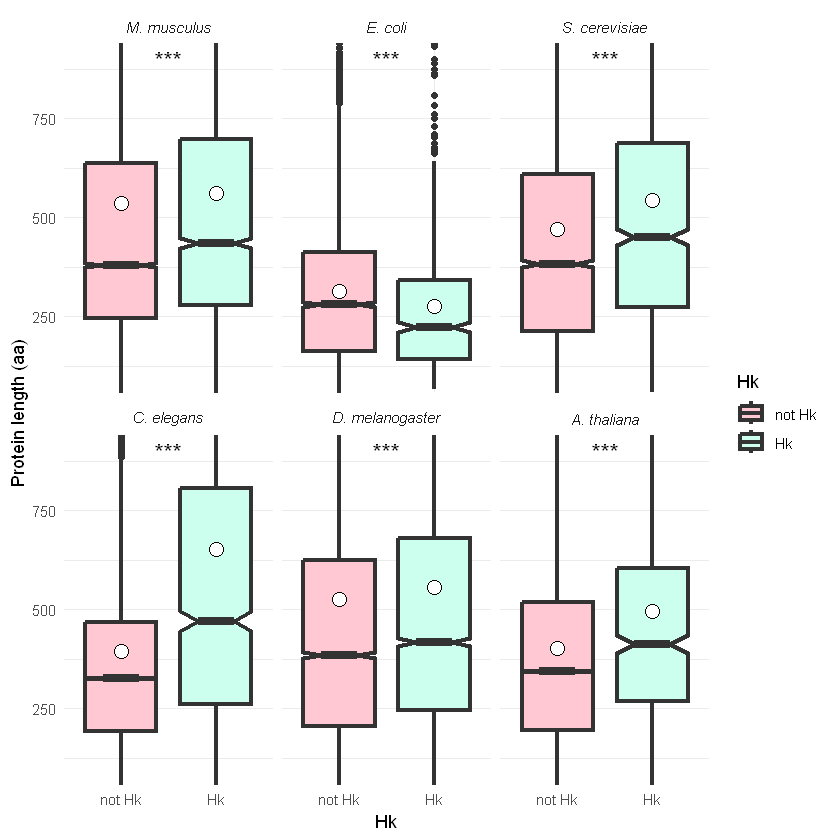

In [8]:

# Convert Organism column AFTER filtering
HkPolyx$Organism <- factor(HkPolyx$Organism, levels = selected_organisms, labels = organism_labels[selected_organisms])

# manual significance values
significance_values_hk <- c(
  "UP000000625" = "***",
  "UP000002311" = "***",
  "UP000001940" = "***",
  "UP000000803" = "***",
  "UP000000589" = "***",
  "UP000006548" = "***",
  "UP000005640" = "***"
)


significance_hk_filtered <- tibble(
  Organism = factor(
    selected_organisms, 
    levels = selected_organisms, 
    labels = organism_labels[selected_organisms]
  ),
  x = rep(1.5, length(selected_organisms)),
  y = rep(900, length(selected_organisms)),
  label = significance_values_hk[selected_organisms]
)

# final plot
HkPolyx %>%
  ggplot(aes(x = Hk, y = Length, fill = Hk)) +
  geom_boxplot(size = 1.2, notch = TRUE) +
  ylab("Protein length (aa)") +
  coord_cartesian(ylim = c(100, 900)) +
  scale_fill_manual(values = c("#ffc8d2", "#ccffee")) +
  stat_summary(fun = "mean", geom = "point", shape = 21, size = 4, color = "black", fill = "white") +
  facet_wrap(~Organism, ncol = 3, labeller = label_parsed, drop = TRUE) +
  theme_minimal() +
  geom_text(data = significance_hk_filtered, aes(x = x, y = y, label = label), size = 5, color = "black", inherit.aes = FALSE)


## HR Visualization - Protein Length by HR

Generating a boxplot of protein length grouped by the number of homorepeats.

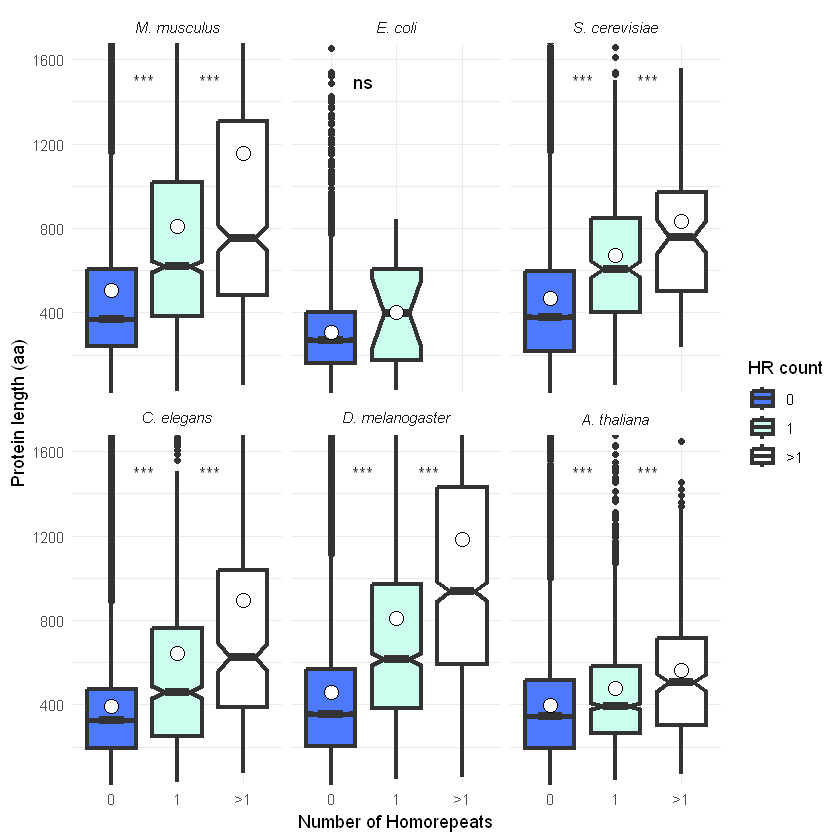

In [9]:

# Manual significance levels
significance_values_HR <- c(
  "UP000000625" = "ns",
  "UP000002311" = "***",
  "UP000001940" = "***",
  "UP000000803" = "***",
  "UP000000589" = "***",
  "UP000006548" = "***",
  "UP000005640" = "***"
)

# Create significance table with two labels for each organism, including one at x = 2.5 for all but E. coli
# Exclude E. coli from the second label position
significance_HR_filtered <- tibble()

# Loop through selected organisms to add the labels dynamically
for (org in selected_organisms) {
  # First label for each organism at x = 1.5
  significance_HR_filtered <- bind_rows(significance_HR_filtered,
    tibble(
      Organism = factor(org, levels = selected_organisms, labels = organism_labels[selected_organisms]),
      x = 1.5,
      y = 1500,
      label = significance_values_HR[org]
    )
  )
  
  # Second label for organisms except E. coli
  if (org != "UP000000625") {
    significance_HR_filtered <- bind_rows(significance_HR_filtered,
      tibble(
        Organism = factor(org, levels = selected_organisms, labels = organism_labels[selected_organisms]),
        x = 2.5,
        y = 1500,
        label = significance_values_HR[org]
      )
    )
  }
}

# final plot
HkPolyx %>%
  ggplot(aes(x = Count_grouped, y = Length, fill = Count_grouped)) +
  geom_boxplot(size = 1.2, notch = TRUE) +
  xlab("Number of Homorepeats") +
  ylab("Protein length (aa)") +
  coord_cartesian(ylim = c(100, 1600)) +
  scale_fill_manual(name = "HR count", values = c("#4d79ff", "#ccffee", "#ffffff")) +
  stat_summary(fun = "mean", geom = "point", shape = 21, size = 4, color = "black", fill = "white") +
  facet_wrap(~Organism, ncol = 3, labeller = label_parsed, drop = TRUE) +
  theme_minimal() +
  geom_text(data = significance_HR_filtered, aes(x = x, y = y, label = label), size = 4, color = "black", inherit.aes = FALSE)


## Check p-values for significance with Wilcoxon test

In [10]:
# Wilcoxon Rank-Sum Test for Plot 1: Protein Length by Housekeeping Status
plot1_stats <- HkPolyx %>%
  group_by(Organism) %>%
  summarise(
    p_value = wilcox.test(Length ~ Hk)$p.value
  ) %>%
  mutate(significance = case_when(
    p_value < 0.001 ~ "***",
    p_value < 0.01 ~ "**",
    p_value < 0.05 ~ "*",
    TRUE ~ "ns"
  ))

print(plot1_stats)

# Apply Wilcoxon test for each organism for 0 vs. 1
plot2_0_1 <- HkPolyx %>%
  group_by(Organism) %>%
  filter(Count_grouped %in% c("0", "1")) %>%
  do({
    # Perform the Wilcoxon test for the current organism
    test_result <- wilcox.test(Length ~ Count_grouped, data = ., correct = TRUE)
    # Return the p-value for the test
    tibble(p_value_0_1 = test_result$p.value)
  })

# View the results
print(plot2_0_1)

# Apply Wilcoxon test for each organism for 1 vs. >1
plot2_1_2 <- HkPolyx %>%
  filter(Organism != "italic('E. coli')") %>%
  group_by(Organism) %>%
  filter(Count_grouped %in% c("1", ">1")) %>%
  do({
    # Perform the Wilcoxon test for the current organism
    test_result <- wilcox.test(Length ~ Count_grouped, data = ., correct = TRUE)
    # Return the p-value for the test
    tibble(p_value_0_1 = test_result$p.value)
  })

print(plot2_1_2)

# A tibble: 6 × 3
  Organism                   p_value significance
  <fct>                        <dbl> <chr>       
1 italic('M. musculus')     5.16e-16 ***         
2 italic('E. coli')         2.48e- 6 ***         
3 italic('S. cerevisiae')   2.11e-11 ***         
4 italic('C. elegans')      3.52e-71 ***         
5 italic('D. melanogaster') 2.24e-14 ***         
6 italic('A. thaliana')     8.26e-14 ***         
# A tibble: 6 × 2
# Groups:   Organism [6]
  Organism                  p_value_0_1
  <fct>                           <dbl>
1 italic('M. musculus')       7.44e-124
2 italic('E. coli')           1.26e-  1
3 italic('S. cerevisiae')     3.30e- 29
4 italic('C. elegans')        9.99e- 41
5 italic('D. melanogaster')   5.63e-106
6 italic('A. thaliana')       1.25e- 28
# A tibble: 5 × 2
# Groups:   Organism [5]
  Organism                  p_value_0_1
  <fct>                           <dbl>
1 italic('M. musculus')        4.80e- 9
2 italic('S. cerevisiae')      4.63e- 4
3 italic('C. ele